In [2]:
import os
import cv2                                 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt             
import seaborn as sn
from zipfile import ZipFile
from sklearn.utils import shuffle 
from sklearn.metrics import confusion_matrix
import tensorflow as tf                
from tqdm import tqdm
import tensorflow.keras.models as Models
import tensorflow.keras.layers as Layers
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import tensorflow.keras.utils as Utils


**Extracting train and test files**

In [3]:
with ZipFile('seg_train.zip', 'r') as zipObj: 
  zipObj.extractall()

with ZipFile('seg_test.zip', 'r') as zipObj: 
  zipObj.extractall()

with ZipFile('seg_pred.zip', 'r') as zipObj: 
  zipObj.extractall()

**Labelling the categories of image data**

In [4]:
categories = ['buildings','forest','glacier','mountain','sea','street']

categories_names_labels = {category_name:i for i, category_name in enumerate(categories)}
print(categories_names_labels)
categories_count = len(categories)

size_of_image = (150, 150)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


**Loading the data**

In [5]:
def data_read():
    data_files = ['./seg_train', './seg_test']
    output = []
    for datafile in data_files:
      images = []
      labels = []        
      for folder in os.listdir(datafile):
          label = categories_names_labels[folder]
          
          for file in tqdm(os.listdir(os.path.join(datafile, folder))):
                
                image_path = os.path.join(os.path.join(datafile, folder), file)
                
                image = cv2.imread(image_path)
                image = cv2.resize(image, size_of_image) 
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                images.append(image)
                labels.append(label)
                
      images = np.array(images, dtype = 'float32')
      labels = np.array(labels, dtype = 'int32')   
        
      output.append((images, labels))

    return output

In [6]:
(trained_images, trained_labels), (test_images, test_labels) = data_read()

100%|██████████| 510/510 [00:00<00:00, 2091.00it/s]


In [46]:
train_count = trained_labels.shape[0]
test_count = test_labels.shape[0]

print ("Number of training data records: {}".format(train_count))
print ("Number of testing data records: {}".format(test_count))

Number of training data records: 14034
Number of testing data records: 3000


**Scaling and Shuffling the data**

In [9]:
trained_images = trained_images / 255.0 
test_images = test_images / 255.0

trained_images, trained_labels = shuffle(trained_images, trained_labels, random_state=35)

**Visualization of data**

In [89]:
def random_image_display(categories, images, labels, nrows, ncols, nimages):
    for i in range(nimages):
      subp = plt.subplot(nrows,ncols, i+1)
      subp.axis('Off')
      plt.figure(figsize=(5,5))
      plt.xticks([])
      plt.yticks([])
      index = np.random.randint(images.shape[0])
      plt.imshow(images[index])
      plt.title(categories[labels[index]])
      plt.show()
      

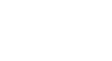

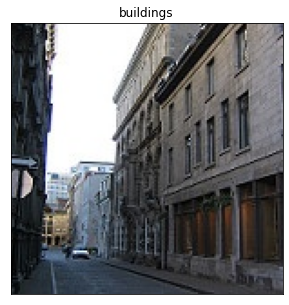

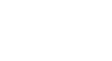

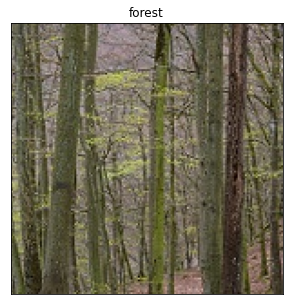

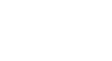

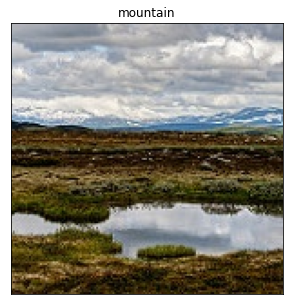

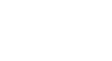

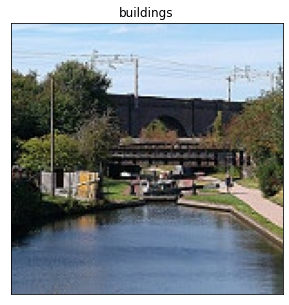

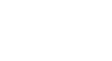

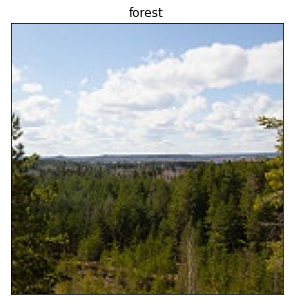

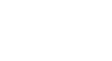

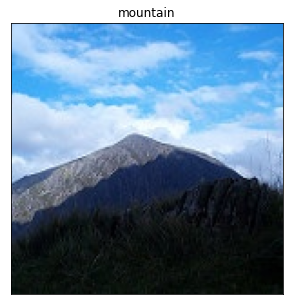

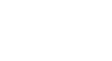

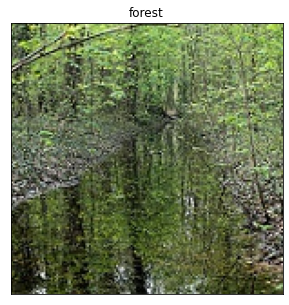

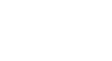

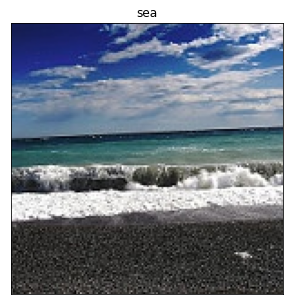

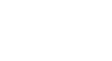

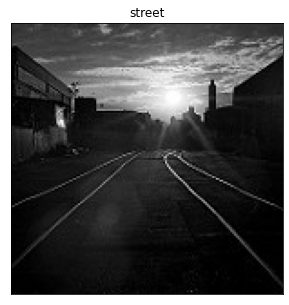

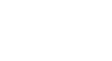

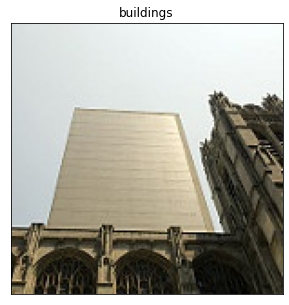

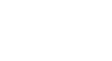

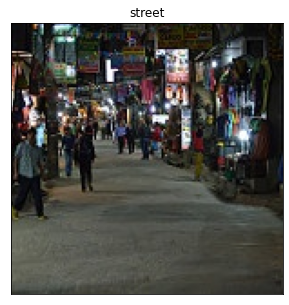

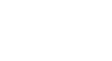

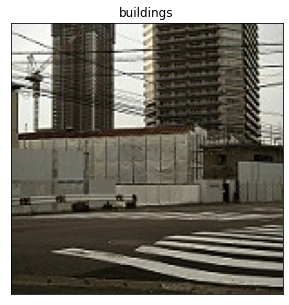

In [91]:
nrows = np.random.randint(1,5)
ncols = np.random.randint(1,5)
no_of_images = nrows * ncols
random_image_display(categories, trained_images, trained_labels, nrows, ncols, no_of_images)

**CNN Model**


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 200)     5600      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 180)     324180    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 29, 29, 180)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 180)       291780    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 140)       226940    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 23, 23, 100)       126100    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 21, 21, 50)        4

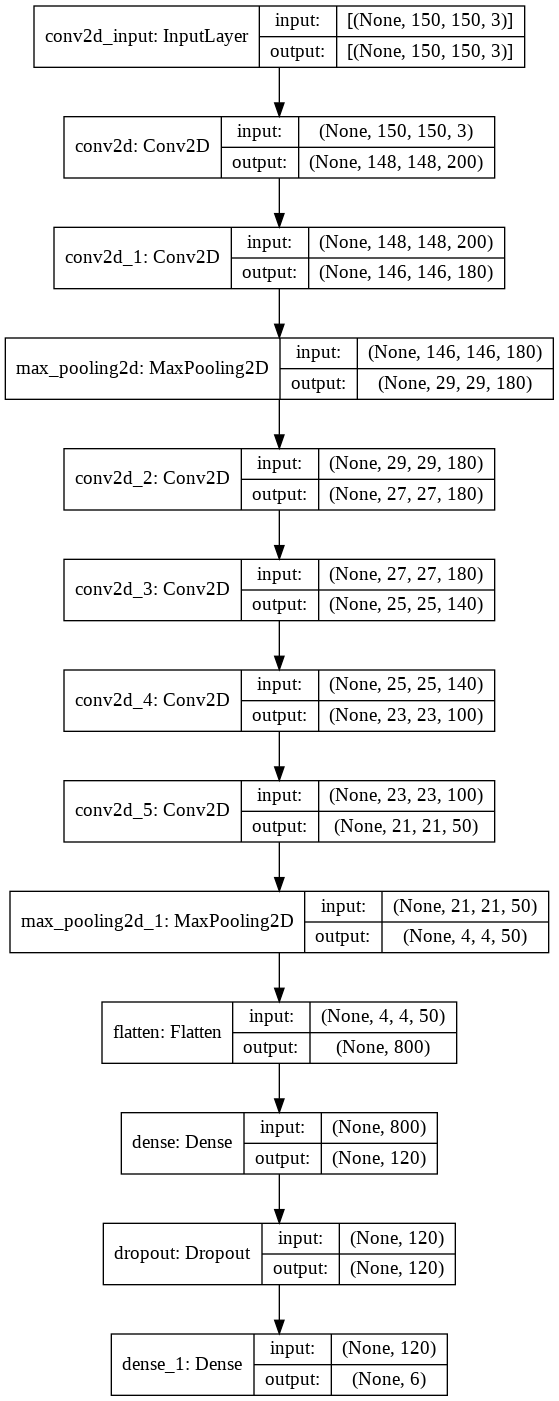

In [14]:
cnn_model = Models.Sequential()

cnn_model.add(Layers.Conv2D(200,kernel_size=(3,3),activation='relu',input_shape=(150,150,3)))
cnn_model.add(Layers.Conv2D(180,kernel_size=(3,3),activation='relu'))
cnn_model.add(Layers.MaxPool2D(5,5))
cnn_model.add(Layers.Conv2D(180,kernel_size=(3,3),activation='relu'))
cnn_model.add(Layers.Conv2D(140,kernel_size=(3,3),activation='relu'))
cnn_model.add(Layers.Conv2D(100,kernel_size=(3,3),activation='relu'))
cnn_model.add(Layers.Conv2D(50,kernel_size=(3,3),activation='relu'))
cnn_model.add(Layers.MaxPool2D(5,5))
cnn_model.add(Layers.Flatten())
cnn_model.add(Layers.Dense(120,activation='relu'))
cnn_model.add(Layers.Dropout(rate=0.25))
cnn_model.add(Layers.Dense(6,activation='softmax'))


cnn_model.summary()
SVG(model_to_dot(cnn_model).create(prog='dot', format='svg'))
Utils.plot_model(cnn_model,to_file='model.png',show_shapes=True)

In [15]:
cnn_model.compile(optimizer="adam",loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [16]:
history = cnn_model.fit(trained_images, trained_labels, batch_size=128, epochs=20, validation_split = 0.2)

Epoch 1/20
88/88 [==============================] - 165s 1s/step - loss: 1.5072 - accuracy: 0.3451 - val_loss: 0.9946 - val_accuracy: 0.5985
Epoch 2/20
88/88 [==============================] - 111s 1s/step - loss: 0.9721 - accuracy: 0.5989 - val_loss: 0.8533 - val_accuracy: 0.6377
Epoch 3/20
88/88 [==============================] - 112s 1s/step - loss: 0.8518 - accuracy: 0.6655 - val_loss: 0.7885 - val_accuracy: 0.7161
Epoch 4/20
88/88 [==============================] - 111s 1s/step - loss: 0.7504 - accuracy: 0.7313 - val_loss: 0.6813 - val_accuracy: 0.7645
Epoch 5/20
88/88 [==============================] - 111s 1s/step - loss: 0.6543 - accuracy: 0.7620 - val_loss: 0.6553 - val_accuracy: 0.7652
Epoch 6/20
88/88 [==============================] - 111s 1s/step - loss: 0.5980 - accuracy: 0.7891 - val_loss: 0.6600 - val_accuracy: 0.7770
Epoch 7/20
88/88 [==============================] - 111s 1s/step - loss: 0.5521 - accuracy: 0.8044 - val_loss: 0.5356 - val_accuracy: 0.8105
Epoch 8/20
88

In [19]:
def accuracy_loss_plot(history):
    fig = plt.figure(figsize=(15,15))

    # Plot accuracy
    plt.subplot(2,2,1)
    plt.plot(history.history['accuracy'], label = "acc", color ='black', linewidth = 2 )
    plt.plot(history.history['val_accuracy'], label = "val_acc", color ='red', linewidth = 2)
    plt.title("Trained Data Accuracy vs Validation data Accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(2,2,2)
    plt.plot(history.history['loss'], label = "loss", color ='black', linewidth = 2)
    plt.plot(history.history['val_loss'],label = "val_loss", color ='red', linewidth = 2)
    plt.title("Trained Data Loss vs Validation Loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

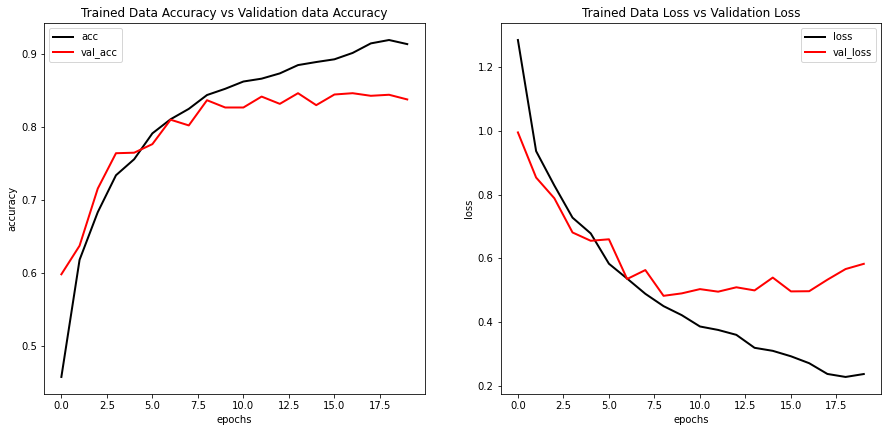

In [20]:
accuracy_loss_plot(history)

In [21]:
test_loss = cnn_model.evaluate(test_images, test_labels)

94/94 [==============================] - 11s 101ms/step - loss: 0.5323 - accuracy: 0.8420


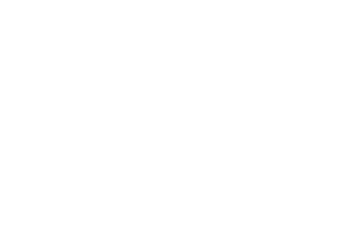

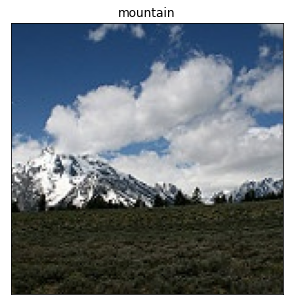

In [93]:
predictions = cnn_model.predict(test_images) 
predict_labels = np.argmax(predictions, axis = 1) 


random_image_display(categories, test_images, predict_labels, 1, 1, 1)

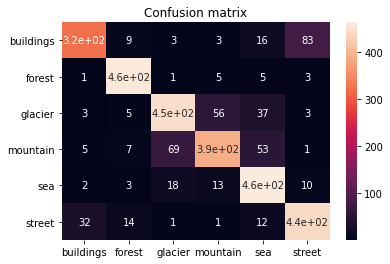

In [94]:
CM = confusion_matrix(test_labels, predict_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, annot_kws={"size": 10},xticklabels=categories,yticklabels=categories, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

**10 Fold Cross Validation**

In [100]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=10, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(trained_images, trained_labels):
  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = cnn_model.fit(trained_images, trained_labels,batch_size=128,epochs=20,verbose=1)
  
  # Increase fold number
  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20
110/110 [==============================] - 9s 85ms/step - loss: 0.7949 - accuracy: 0.7061
Epoch 2/20
110/110 [==============================] - 9s 79ms/step - loss: 0.6439 - accuracy: 0.7670
Epoch 3/20
110/110 [==============================] - 9s 79ms/step - loss: 0.5225 - accuracy: 0.8140
Epoch 4/20
110/110 [==============================] - 9s 80ms/step - loss: 0.3836 - accuracy: 0.8654
Epoch 5/20
110/110 [==============================] - 9s 80ms/step - loss: 0.2925 - accuracy: 0.9030
Epoch 6/20
110/110 [==============================] - 9s 80ms/step - loss: 0.1984 - accuracy: 0.9362
Epoch 7/20
110/110 [==============================] - 9s 79ms/step - loss: 0.1365 - accuracy: 0.9612
Epoch 8/20
110/110 [==============================] - 9s 79ms/step - loss: 0.0929 - accuracy: 0.9768
Epoch 9/20
110/110 [==============================] - 9s 79ms/step - loss: 0.0684 - accuracy: 0

**Transfer Learning by VGG16 to improve accuracy**

In [41]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(trained_labels, 6)
y_test = np_utils.to_categorical(test_labels, 6)

In [42]:
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

vgg_conv = VGG16(weights='imagenet',
                  include_top=False,input_shape=(150,150,3))
## Disabling training from VGG layers
vgg_conv.trainable=False

## Instantiating model
vgg_conv.trainable=False
transfer_model = Models.Sequential()
transfer_model.add(vgg_conv)
transfer_model.add(Layers.Flatten())
transfer_model.add(Layers.Dropout(0.25))
transfer_model.add(Layers.Dense(64, activation='relu'))
transfer_model.add(Layers.Dropout(0.25))
transfer_model.add(Layers.Dense(6, activation='softmax'))


## Model summary
transfer_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                524352    
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 390       
Total params: 15,239,430
Trainable params: 524,742
Non-trainable params: 14,714,688
____________________________________

**Compiling the model**

In [43]:
optimizer = Adam(lr=0.2e-3, beta_1=0.9, beta_2=0.999, amsgrad=False)

transfer_model.compile(optimizer,loss='binary_crossentropy',metrics=["accuracy"])


**Model training**

In [45]:
train_gen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# fits the model on batches with real-time data augmentation:
history = transfer_model.fit_generator(train_gen.flow(trained_images, y_train, batch_size=32),
                              steps_per_epoch=len(trained_images) / 32, epochs=5,
                              validation_data = (test_images, y_test))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
438/438 [==============================] - 78s 178ms/step - loss: 0.1679 - accuracy: 0.8041 - val_loss: 0.1207 - val_accuracy: 0.8583
Epoch 2/5
438/438 [==============================] - 79s 180ms/step - loss: 0.1602 - accuracy: 0.8118 - val_loss: 0.1202 - val_accuracy: 0.8547
Epoch 3/5
438/438 [==============================] - 79s 179ms/step - loss: 0.1589 - accuracy: 0.8119 - val_loss: 0.1186 - val_accuracy: 0.8567
Epoch 4/5
438/438 [==============================] - 78s 178ms/step - loss: 0.1519 - accuracy: 0.8239 - val_loss: 0.1153 - val_accuracy: 0.8643
Epoch 5/5
438/438 [==============================] - 79s 180ms/step - loss: 0.1497 - accuracy: 0.8217 - val_loss: 0.1114 - val_accuracy: 0.8690
